In [1]:
from pathlib import Path
import sys
project_path = str(Path.cwd().parent.parent.parent)
sys.path.append(project_path)
import sisclab22p6.data

from dscribe.descriptors import CoulombMatrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score

In [66]:
filepath_data = "../../../data/jij"
filename_table = "d_block_magnetic_data_modified.csv"
filename_structures = "dimer_clusters.extxyz"
table = sisclab22p6.data.load_jij_data(filepath = filepath_data, 
                                       filename_table=filename_table, 
                                       filename_structures=filename_structures)

Loaded Number samples: 1730, 1730.


----------> Very simple data exploration for J:

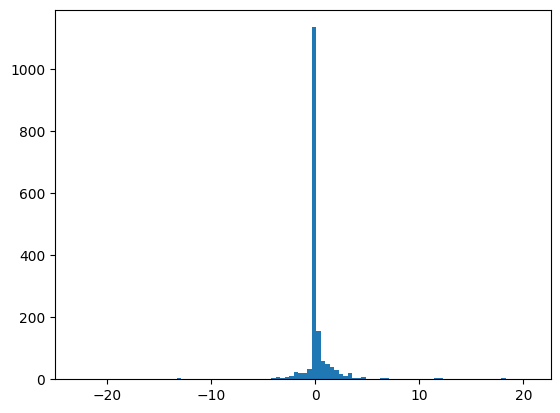

In [3]:
_ = plt.hist(np.array(table['J']), bins = 100)

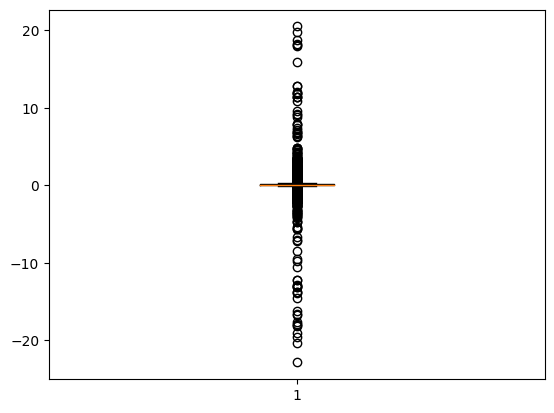

In [4]:
_ = plt.boxplot(np.array(table['J']))

----------> modeling using CM descriptors

In [67]:
max_atoms = max([table['structure'][i].get_global_number_of_atoms() for i in range(len(table))])

In [68]:
cm = CoulombMatrix(
    n_atoms_max = max_atoms,
    permutation='sorted_l2',
    flatten = False
)

In [70]:
def get_vector_representation(index):
    if index >= 0 and index < 1730:
        atoms_structure = table['structure'][index]
        coulomb_matrix = cm.create(atoms_structure)
        coulomb_vector = np.array(coulomb_matrix[np.tril_indices(max_atoms, k = 0)])
        return coulomb_vector
    else:
        print("error: index must be from the table: [0,1729]")
        
vectors = [get_vector_representation(i) for i in range(len(table))]
table['coulomb_vectors'] = vectors

In [71]:
X = np.zeros(len(table['coulomb_vectors'][0]))
for i in range(len(table)):
    X = np.vstack((X,table['coulomb_vectors'][i]))
X = X[1:,:]
Y = table['J'].to_numpy()

In [72]:
print("Check for X:")
print(type(X))
print(type(X[0]))
print(X.shape)
print("Check for Y:")
print(type(Y))
print(type(Y[0]))
print(Y.shape)

Check for X:
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(1730, 105)
Check for Y:
<class 'numpy.ndarray'>
<class 'numpy.float64'>
(1730,)


In [74]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

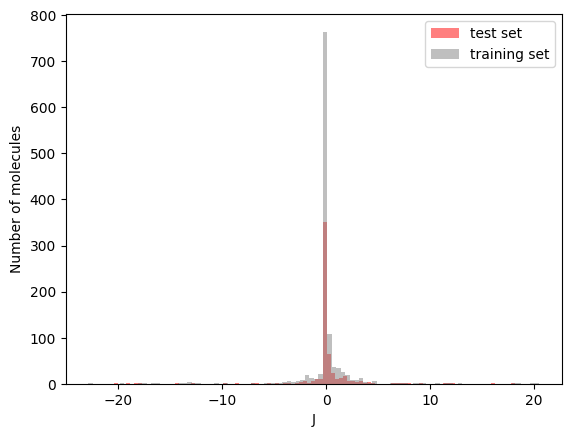

In [75]:
plt.hist(y_test, bins=100, density=False, alpha=0.5, facecolor='red', label='test set')
plt.hist(y_train, bins=100, density=False, alpha=0.5, facecolor='gray', label='training set')
plt.xlabel("J")
plt.ylabel("Number of molecules")
plt.legend()
plt.show()

In [76]:
alpha = np.logspace(-4, -2, 3)
gamma = np.logspace(-4, -2, 3)
cv_number = 3
kernel = 'rbf'
scoring_function = 'neg_mean_absolute_error'
grid_search = GridSearchCV(KernelRidge(),  
                           [{'kernel':[kernel],'alpha': alpha, 'gamma': gamma}], 
                           cv = cv_number, 
                           scoring = scoring_function,
                           verbose=1000)
grid_search.fit(X, Y)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START alpha=0.0001, gamma=0.0001, kernel=rbf......................
[CV 1/3; 1/9] END alpha=0.0001, gamma=0.0001, kernel=rbf;, score=-1.761 total time=   0.2s
[CV 2/3; 1/9] START alpha=0.0001, gamma=0.0001, kernel=rbf......................
[CV 2/3; 1/9] END alpha=0.0001, gamma=0.0001, kernel=rbf;, score=-0.294 total time=   0.2s
[CV 3/3; 1/9] START alpha=0.0001, gamma=0.0001, kernel=rbf......................
[CV 3/3; 1/9] END alpha=0.0001, gamma=0.0001, kernel=rbf;, score=-0.489 total time=   0.2s
[CV 1/3; 2/9] START alpha=0.0001, gamma=0.001, kernel=rbf.......................
[CV 1/3; 2/9] END alpha=0.0001, gamma=0.001, kernel=rbf;, score=-1.765 total time=   0.2s
[CV 2/3; 2/9] START alpha=0.0001, gamma=0.001, kernel=rbf.......................
[CV 2/3; 2/9] END alpha=0.0001, gamma=0.001, kernel=rbf;, score=-0.299 total time=   0.2s
[CV 3/3; 2/9] START alpha=0.0001, gamma=0.001, kernel=rbf.......................
[

GridSearchCV(cv=3, estimator=KernelRidge(),
             param_grid=[{'alpha': array([0.0001, 0.001 , 0.01  ]),
                          'gamma': array([0.0001, 0.001 , 0.01  ]),
                          'kernel': ['rbf']}],
             scoring='neg_mean_absolute_error', verbose=1000)

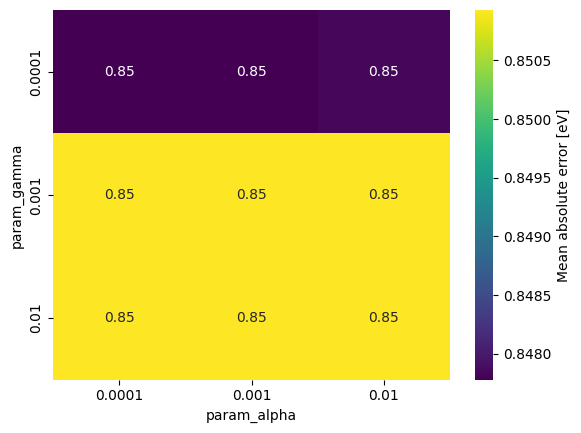

The best combinations of parameters are {'alpha': 0.0001, 'gamma': 0.0001, 'kernel': 'rbf'} with a score of 0.848 eV on the validation set.


In [77]:
import pandas as pd
import seaborn as sns

results = pd.DataFrame(grid_search.cv_results_)
#pd.DataFrame(grid_search.cv_results_)

pvt = pd.pivot_table(results, values='mean_test_score', 
                     index='param_gamma', columns='param_alpha')
heatmap = sns.heatmap(-pvt, annot=True, cmap='viridis', cbar_kws={'label': "Mean absolute error [eV]"})
figure = heatmap.get_figure()
plt.show()


print("The best combinations of parameters are %s with a score of %0.3f eV on the validation set."
      % (grid_search.best_params_, -grid_search.best_score_))